# 作业要求

- [x] 数据预处理
- [x] 将样本按7:3分为训练集和测试集
- [x] 分别用 Normal Equation 和梯度下降求得权重
- [x] 权重的方法比较和结果
- [x] 考虑幂次特征

# 数据预处理

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *

1. 首先选取数据集中幸福指数分数`Ladder score`和6个特征
2. 数据集出现缺失值，用该列特征的平均值填充，用`SimpleImputer`类实现
3. 用`StandardScaler`实现标准化
4. 操作后的数据转化为数据框存储为`df_happy`
5. 进行描述性统计和可视化

In [39]:
WHR = pd.read_csv("WHR2023.csv")

# 特征选择(第一列：score，后几列：特征)
data = WHR.iloc[:,[1,5,6,7,8,9,10]]

# 缺失值补全
data = SimpleImputer().fit_transform(data)

# 标准化
data = StandardScaler().fit_transform(data)

# 转化为dataframe
df_happy = pd.DataFrame(data, columns=['Ladder score', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption'])

# 描述性统计
#print(df_happy.describe())

使用`matplotlib`中的`subplot`函数得到八个子图的集合命名为`ax`，用`for`循环遍历每一个特征并在相应位置作图。Kernel density estimate (KDE)是一种非参数估计pdf的方法，如此作图可以使分布连续。

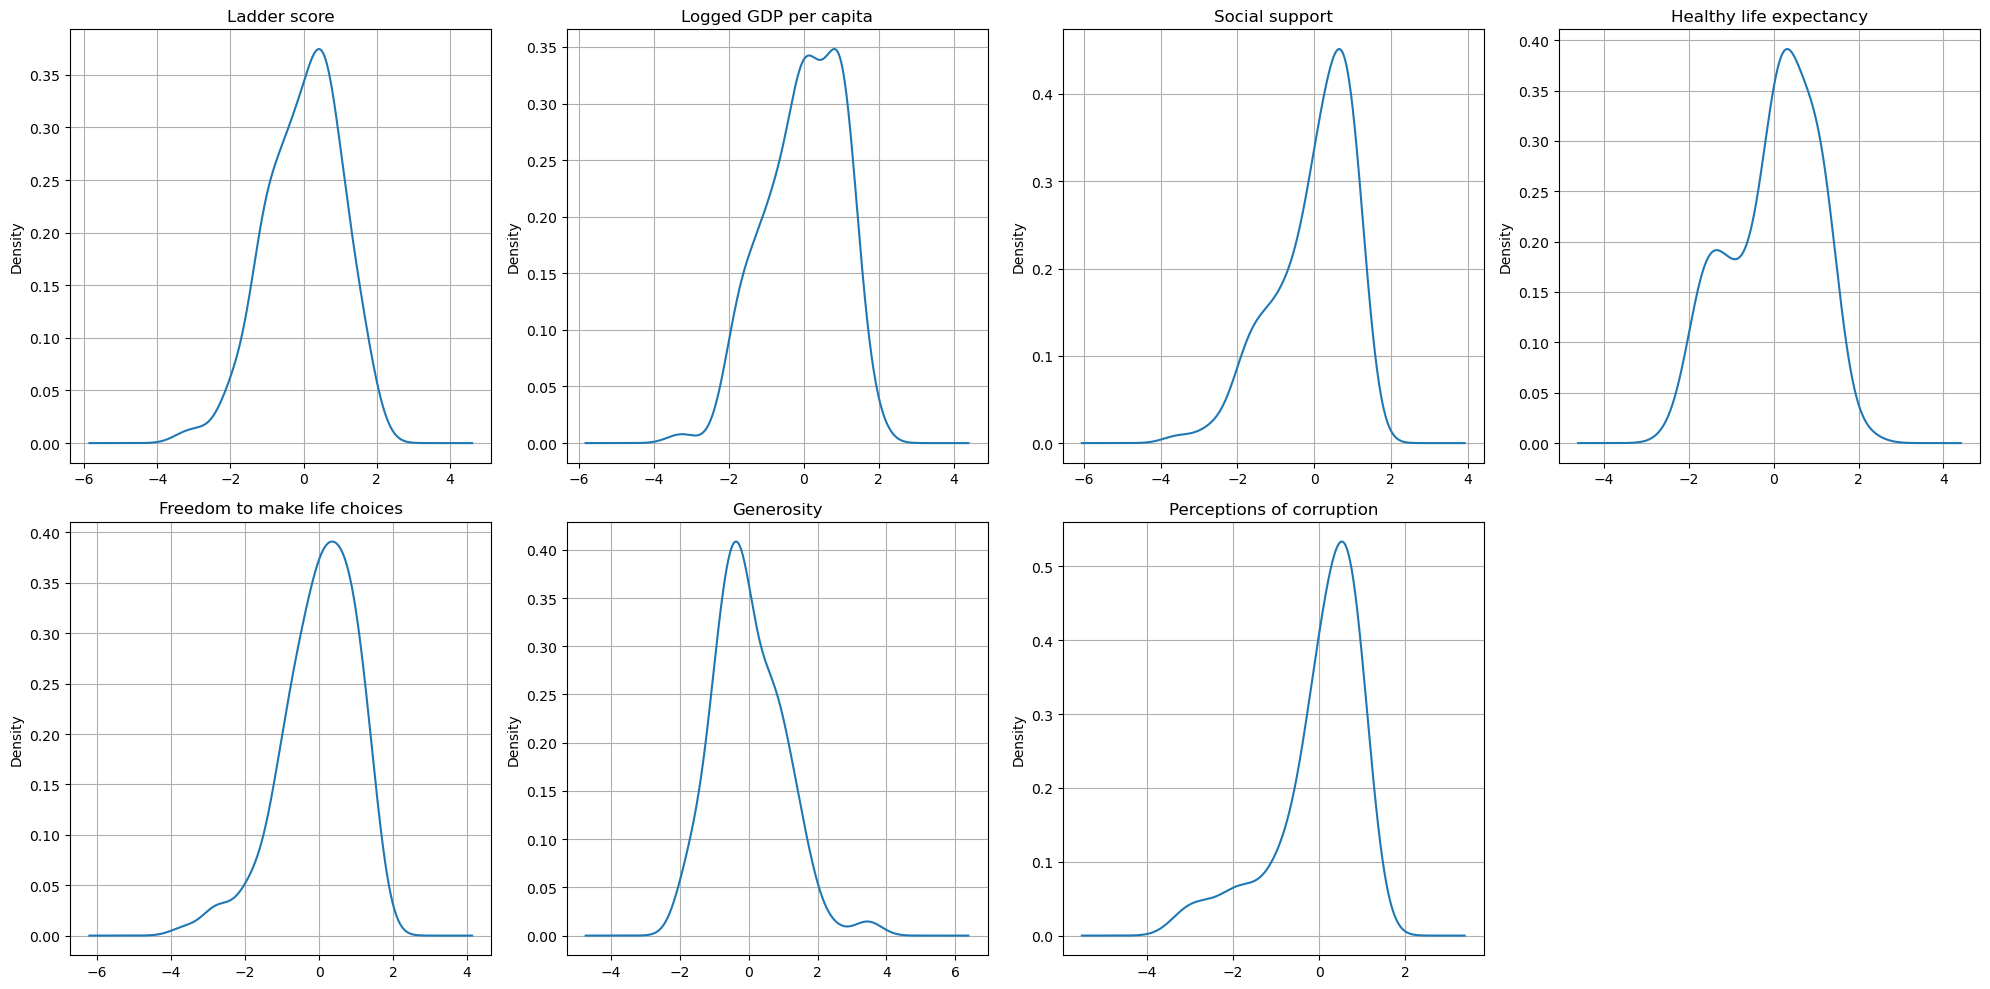

In [4]:
# 可视化
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for idx, col in enumerate(df_happy.columns):
    df_happy[col].plot(kind='kde', ax=ax[idx//4, idx%4])
    ax[idx//4, idx%4].set_title(col)
    ax[idx//4, idx%4].grid(True)

ax[1, 3].axis('off')

plt.tight_layout()
plt.show()

# 分样本

将数据集分成训练集和测试集，比例为7:3，有两种方法。

方法一：调包

```python
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_happy, test_size=0.3, random_state=22)
```

方法二：用`sample`函数(后发现只适用于df，不合适)

```python
shuffle = df_happy.sample(frac=1, random_state=22)
split = int(0.7 * len(df_happy))
train = shuffle.iloc[:split]
test = shuffle.iloc[split:]
print(f"训练集{train.shape[0]}个，测试集{test.shape[0]}个")
```

In [60]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, random_state=22)

# 求权重

假设函数的形式为

$$
h_{\theta}(x^i)=\theta_0+\theta_1x_1^i+\cdots+\theta_nx_n^i
$$

矢量化表示为

$$
\underbrace{
\begin{bmatrix}
1 & x^1_1 & \cdots & x^1_j & \cdots & x^1_n\\
1 & x^2_1 & \cdots & x^1_j & \cdots & x^2_n\\
\vdots & \vdots & \ddots & \vdots & & \vdots\\
1 & x^i_1 & \cdots & x^i_j &  & x^i_n\\
\vdots & \vdots & & & \ddots & \vdots\\
1 & x^m_1 & \cdots & x^m_j & \cdots & x^m_n
\end{bmatrix}
}_{m\times n}

\underbrace{
\begin{bmatrix}
\theta_0\\
\theta_1\\
\vdots\\
\theta_j\\
\vdots\\
\theta_n
\end{bmatrix}
}_{n\times 1}
=
\underbrace{
\begin{bmatrix}
\hat{y}_1\\
\hat{y}_2\\
\vdots\\
\hat{y}_i\\
\vdots\\
\hat{y}_m
\end{bmatrix}
}_{m\times 1}
$$

## Normal Equation

$$
\Theta=(X^TX)^{-1}X^TY
$$

设计函数，输入X和Y便能通过解析解公式求出$\Theta$

In [68]:
m = df_happy.shape[0]
print(m)

137


(95, 7)

In [74]:
def add_one(X):
    m1 = X.shape[0]
    one = np.ones(m1).reshape(m1,1)
    X = np.hstack([one, X])
    return X

In [83]:
def normal(X, Y, lamda):
    L = lamda * np.identity(X.shape[1]) # 正则化
    L[0][0] = 0
    P = np.linalg.pinv(X.T @ X + L) @ X.T @ Y
    return P

In [84]:
X_train = add_one(train[:,1:])
Y_train = train[:,0]
X_test = add_one(test[:,1:])
Y_test = test[:,0]
m2 = X_test.shape[0]

P = normal(X_train,Y_train, 0.1)
cost = 1/(2*m2) * ((X_test @ P - Y_test).T @ (X_test @ P - Y_test))
print(f"参数是{P}，损失是{cost:.4f}")

参数是[ 0.00966087  0.17898223  0.47965942  0.15279653  0.20686355  0.02089675
 -0.10554351]，损失是0.0999


参数是`[ 0.00966087  0.17898223  0.47965942  0.15279653  0.20686355  0.02089675  -0.10554351]`，损失是0.0999

这仅仅是一次随机抽取训练集的结果，要保证稳健性需要多次抽取，得到效果最好的一次。现在原有的基础上封装一个循环

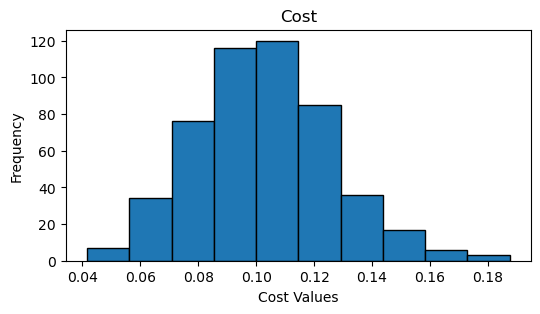

In [117]:
P_all = np.zeros((500,7))
cost_all = np.zeros((500,1))

for i in range(500):
    # 抽样
    train, test = train_test_split(data, test_size=0.3)
    # 准备X和Y
    X_train = add_one(train[:,1:])
    Y_train = train[:,0]
    X_test = add_one(test[:,1:])
    Y_test = test[:,0]
    m2 = X_test.shape[0]
    # 参数和损失
    P = normal(X_train,Y_train, 0.1)
    cost = 1/(2*m2) * ((X_test @ P - Y_test).T @ (X_test @ P - Y_test))
    P_all[i] = P
    cost_all[i] = cost

plt.figure(figsize=(6,3))
plt.hist(cost_all, bins=10, edgecolor="k")
plt.title("Cost")
plt.xlabel("Cost Values")
plt.ylabel("Frequency")
plt.show()

In [119]:
min_idx = np.argmin(cost_all)
min_cost = cost_all[min_idx]
best_P = P_all[min_idx]
print(f"最佳参数是：{best_P}")

最佳参数是：[-0.00359254  0.18448015  0.48851371  0.11518319  0.24318951  0.00458211
 -0.10384537]


最佳的参数为`[-0.00359254  0.18448015  0.48851371  0.11518319  0.24318951  0.00458211  -0.10384537]`

## 梯度下降

$$
\Theta = \Theta - \frac{\alpha}{m}X^T(X\Theta-Y)
$$

为了避免过拟合，我们用L2正则化在损失函数里加入参数的平方和
$$
J_{L2}(\theta)=J(\theta)+\frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2
$$

In [145]:
def Cost(X,Y,P,lamda):
    m = len(Y)
    reg = lamda / (2*m) * np.sum(P[1:] ** 2)
    Cost = 1/(2*m) * ((X @ P - Y).T @ (X @ P - Y)) + reg
    return Cost

0.08615011529124332


这里我尝试用已有的`X_train`，`Y_train`等变量代入Cost函数中，输出一个标量，没什么问题。但跑梯度下降时会报错，说
```python
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[140], line 5
      3 lamda = 0.1
      4 P0 = np.random.randn(7,1) # 初始化参数(用0初始化会有问题)
----> 5 P_final, cost_history = gradient_descent(X_train, Y_train, P0, a, iter, lamda)

Cell In[133], line 10, in gradient_descent(X, Y, P, a, iter, lamda)
      8     gradient = X.T @ (X @ P - Y) + reg
      9     P = P - a / m * gradient
---> 10     cost_history[i] = Cost(X,Y,P,lamda)
     11 return P,cost_history

Cell In[139], line 5, in Cost(X, Y, P, lamda)
      3 reg = lamda / (2*m) * np.sum(P[1:] ** 2)
      4 Cost = 1/(2*m) * ((X @ P - Y).T @ (X @ P - Y)) + reg
----> 5 return Cost.item()

ValueError: can only convert an array of size 1 to a Python scalar
```

我猜可能是矩阵运算符`@`的问题，因为这个运算在python 3.5+里才有，算是比较新。也确实如此，待我将`@`换成诸如`np.dot()`等形式后就停止报错

In [149]:
def Cost(X,Y,P,lamda):
    m = len(Y)
    reg = lamda / (2*m) * np.sum(P[1:] ** 2)
    predictions = X.dot(P)
    errors = np.subtract(predictions, Y)
    Cost = (1 / (2 * m)) * (np.sum(np.square(errors)) + reg)
    return Cost

同样，在梯度更新时也加入正则化项，但第一项常数项不要正则化

In [229]:
def gradient_descent(X,Y,P,a,iter,lamda):
    m = len(Y)
    cost_history = np.zeros(iter)

    for i in range(iter):
        reg_term = lamda / m * P
        reg_term[0] = 0     # 常数项避免正则化
        gradient = np.dot(X.T,(np.dot(X,P))) + reg_term
        P = P - a / m * gradient
        cost_history[i] = Cost(X,Y,P,lamda)
    return P,cost_history

In [240]:
# X和Y
train, test = train_test_split(data, test_size=0.3)
X_train = add_one(train[:,1:])
Y_train = train[:,0]
X_test = add_one(test[:,1:])
Y_test = test[:,0]

# 设定超参数
a = 0.01
iter = 1000
lamda = 0.01
P0 = np.random.randn(7,1) # 初始化参数(用0初始化会有问题)
P, cost_history = gradient_descent(X_train, Y_train, P0, a, iter, lamda)
print(f"收敛时参数为{P.reshape(1,7)}，损失为{cost_history[-1]:.4f}")

收敛时参数为[[-0.00447103  0.17209859 -0.08333882 -0.08813346  0.0238222   0.02177015
   0.02777599]]，损失为53.0216


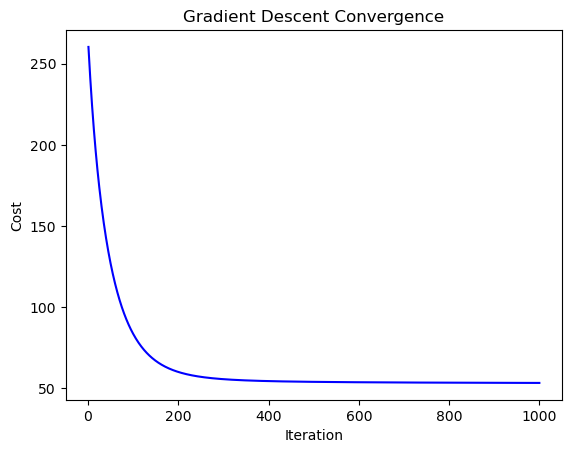

In [241]:
plt.plot(range(1, iter + 1), cost_history, color='blue')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Gradient Descent Convergence')
plt.show()

收敛时参数为[[ 0.00077251  0.02568604 -0.01492614 -0.01275209  0.00775368  0.00172132   0.00779899]]，损失为44.9063

可见相比于Normal Equation，梯度下降的损失非常大

# 考虑幂次特征

以梯度下降为例，我用`PolynomialFeatures`函数考虑了X中所有的高次项，共28个（包括$x^0$），但并没有出现过拟合的现象，而且损失没有出现显著下降

In [247]:
from sklearn.preprocessing import PolynomialFeatures

def polynomial_features(X, degree=2):
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(X)

# X和Y
train, test = train_test_split(data, test_size=0.3)
X_train = add_one(train[:,1:])
Y_train = train[:,0]
X_test = add_one(test[:,1:])
Y_test = test[:,0]
X_poly = polynomial_features(X_train[:, 1:])

# 设定超参数
a = 0.01
iter = 1000
lamda = 0.01
P0 = np.random.randn(28,1) # 初始化参数(用0初始化会有问题)
P, cost_history = gradient_descent(X_poly, Y_train, P0, a, iter, lamda)
print(f"收敛时参数为{P.reshape(1,28)}，损失为{cost_history[-1]:.4f}")

收敛时参数为[[ 0.2852588   0.8302486  -0.46128349 -0.52975144  0.06251134 -0.06056986
  -0.09177361 -0.8022158   0.7172624   1.30850172 -0.46720301 -0.43737056
  -0.27910414 -0.33779756 -0.54882724  0.0500545   0.20307463 -0.11055601
  -0.55402085  0.73908995 -0.03697582  0.44601426 -0.0061201   0.31485551
   0.4667257  -0.08726318 -0.074732    0.09964438]]，损失为54.6176


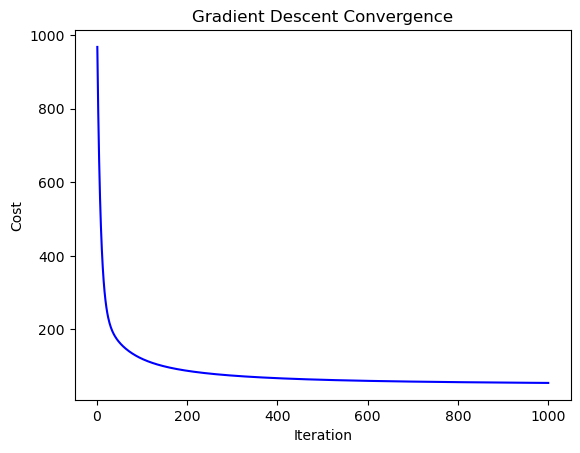

In [248]:
plt.plot(range(1, iter + 1), cost_history, color='blue')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Gradient Descent Convergence')
plt.show()

# 附一：课堂笔记

## 作业回顾

把目标函数表示为已知函数的线性叠加

线性模型（跟线性回归不一样）：指定$f_n$学习$\theta_n$，凸优化问题，保证有最优解
$$
h_{\theta}(\vec{x})=\sum_{n=0}^{\infty}\theta_nf_n(\vec{x})
$$

其中$\theta_n$是权重，$f_n$是特征函数

非线性模型：学习$f_n$，$\theta_n$，表征学习，非凸优化问题

训练集$\mathcal{D}=\{(x,y)\}_{i=1}^{m}$

优化问题

$$
J(\theta)=\frac{1}{2m}\sum_{i=1}^m(h_{\theta}(x^i)-y^i)^2
$$

$$
\frac{\partial}{\partial \theta_j}J(\theta)=\frac 1m\sum_{i=1}^m(h_{\theta}(x^i)-y^i)x_j^i \quad j=1,\cdots,n
$$

矢量化编程，利用GPU核多的优势，科学计算。`numpy`专门做这个

$$
J(\Theta)=\frac{1}{2m}(X\Theta-Y)^T(X\Theta-Y)
$$

$$
\Theta=\Theta-\alpha\cdot \underbrace{\frac 1m X^T(X\Theta-Y)}_{\text{偏导数}}
$$

解析解（误差来源于伪逆，因为$X$不满足$|X|\neq 0$）

$$
\Theta=(X^TX)^{-1}X^TY
$$

$x_j^i$随机取$[0,1]$，高次幂后一整列接近于0，不满足求逆条件。因此需要**标准化**

## 数据规范化

1. 最大最小

$$
x=\frac{x-\min}{\max-\min}
$$

2. z-score

$$
x=\frac{x-\bar{x}}{\sigma_x}
$$

## 关于超参数

过学习（过拟合），把系统误差$\xi$也学进去了，会导致预测效果变差

系统内禀误差

$$
\sqrt{\frac 1m\sum_{i=1}^m\xi_i^2}
$$

$n\uparrow$，欠拟合$\rightarrow$过拟合，调超参数$n$一定要用到训练误差和测试误差的对比图

VC维数：复杂性度量，$n$越大，复杂度越高

梯度下降的超参数：$n,\alpha,nstep,\Theta_0$

要取适合每个维度的$\alpha$很难

## 正则化

要避免过学习，避免cost跌倒谷底，有一种系统的方法：正则化

$\theta_0$不包括在正则化里，所以

$$
L=\lambda\begin{bmatrix}
0 & & & & \\
& 1 & & & \\
& & 1 & &\\
& & & \ddots &\\
& & & & 1
\end{bmatrix}
$$

L1: Lasso正则化

$$
+\lambda \sum_{i=1}^n|\theta_i|
$$

L2: Ridge正则化

$$
+\lambda \sum_{i=1}^n\theta_i^2
$$


拟牛顿法 BFGS

随机梯度下降

$$
\theta_j=\theta_j-\alpha (h(x)-y)x_j
$$

每次只算一个样本，矩阵形式随机选一行代进去

数据库：UCI，kaggle